# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate unit $u$;
* $units(i):$ all input units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on unit $u$ as a binary vector;
* $UnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input unit.

## Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Unit Agreement

The worker-unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the units they have worked on, weighted by the unit and annotation quality. It calculates how much a worker disagrees with the crowd on a unit basis. Through the weighted average, units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), UnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Unit-Annotation Score (UAS)

The unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

## Run the metrics


In [1]:
import pkg_resources
pkg_resources.require("crowdtruth==2.0")
import crowdtruth
from crowdtruth.configuration import DefaultConfig
import logging
import warnings; warnings.simplefilter('ignore')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

class config(DefaultConfig):
    inputColumns = ["index", "bin", "doc_len", "document_id", "document_body", "document_title", "rel", 
                    "topic", "topic_description", "topic_query"]
    outputColumns = ["relevant_snippets"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_separator = ","
    annotation_vector = []
    
    def processJudgments(self, judgments):
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: x.replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: x.replace(']',''))
            judgments[col] = judgments[col].apply(lambda x: x.replace('"',''))
            judgments[col] = judgments[col].apply(lambda x: x.replace(' ',','))
        return judgments

### Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [2]:
# Read data
data, config = crowdtruth.load(
    directory = "../crowdsourcing_data/Pilot_2P-RndPar-NoHigh/",
    config = config()
)

data['judgments'].head()

INFO:root:Config loaded
INFO:root:Found 2 files
INFO:root:Processing f1202124_anonymized.csv
INFO:root:Values not stored as dictionary
INFO:root:Processing f1202123_anonymized.csv
INFO:root:Values not stored as dictionary


,output.relevant_snippets,output.relevant_snippets.count,output.relevant_snippets.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,
2967761149,{u's6': 1},1,1,2017-10-29 08:00:07,2017-10-29 07:59:46,64eeff090a45ee97db4b629d29ddce9ce0fb98213bb116...,1429460886,21,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...
2967943689,"{u's2': 1, u's6': 1, u's3': 1, u's1': 1, u's4'...",6,6,2017-10-29 12:18:54,2017-10-29 12:18:20,ec42e54df81e9f44e9589cc3f86799eee34db02e603410...,1429460886,34,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...
2968037143,"{u's4': 1, u's6': 1, u's5': 1, u's3': 1, u's2'...",5,5,2017-10-29 13:32:50,2017-10-29 13:32:28,bd19aa2adb5a1df22ccaaeda766439016683263b10e769...,1429460886,22,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...
2968053785,"{u's4': 1, u's6': 1, u's5': 1, u's2': 1, u's7'...",7,7,2017-10-29 13:44:07,2017-10-29 13:43:51,61fd51974b151b65bb26beaf6c7ad73b2ac54a3cfb28ec...,1429460886,16,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...
2968063869,"{u's6': 1, u's5': 1, u's4': 1, u's7': 1, u's3'...",7,7,2017-10-29 13:50:35,2017-10-29 13:50:21,20e2a01474c1e2433f66ca064b7f8c1cbf79b5273ca91a...,1429460886,14,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...


In [3]:
results = crowdtruth.run(data, config)

INFO:root:1 iterations; max d= 0.976514430385 ; wqs d= 0.543419086973; sqs d= 0.458320786266; rqs d= 0.0
INFO:root:2 iterations; max d= 0.141626767492 ; wqs d= 0.0650544527968; sqs d= 0.0341202836312; rqs d= 0.0
INFO:root:3 iterations; max d= 0.0175808893406 ; wqs d= 0.00374905397558; sqs d= 0.00329466747564; rqs d= 0.0
INFO:root:4 iterations; max d= 0.0043637032693 ; wqs d= 0.00101040935085; sqs d= 0.00117354287779; rqs d= 0.0
INFO:root:5 iterations; max d= 0.00105219373174 ; wqs d= 0.000214981824984; sqs d= 0.000280535177376; rqs d= 0.0
INFO:root:6 iterations; max d= 0.000299555776463 ; wqs d= 7.46733932666e-05; sqs d= 5.86098460376e-05; rqs d= 0.0


In [4]:
results["units"].head(5)

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.rel,input.topic,input.topic_description,input.topic_query,job,output.relevant_snippets,output.relevant_snippets.annotations,output.relevant_snippets.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,,,,
1429460886,35.800000,2,578,<p>The earnest figures speaking to us from the...,918882,Gateway to Madness,7,2,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...,"{u's3': 11, u's2': 11, u's1': 11, u's7': 11, u...",80,7,15,0.784495,"{u's3': 0.823771157004, u's2': 0.830589880895,...",0.722172,"{u's3': 0.733333333333, u's2': 0.733333333333,..."
1429460887,54.000000,2,481,<p>Fifty-three more bodies were discovered tod...,1187935,Cult Toll Rises In Uganda As More Dead Are Found,8,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...,"{u'none': 1, u's8': 8, u's3': 9, u's2': 9, u's...",92,11,15,0.636739,"{u'none': 0.0393626994437, u's8': 0.6414851700...",0.553214,"{u'none': 0.0666666666667, u's8': 0.5333333333..."
1429460888,70.666667,2,559,<p>LEAD:</p> <p>WOMBS AND ALIEN SPIRITS</p> <p...,337774,WOMEN POSSESSED,9,2,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...,"{u's9': 10, u's18': 4, u's3': 7, u's2': 2, u's...",73,16,15,0.522828,"{u's9': 0.675332871138, u's18': 0.274892306832...",0.480538,"{u's9': 0.666666666667, u's18': 0.266666666667..."
1429460889,78.333333,2,524,<p>LEAD: A judge in Federal Bankruptcy Court r...,42094,CHURCH ORDERED TO RETURN $6 MILLION TO GIVER,10,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...,"{u'none': 5, u's8': 8, u's3': 8, u's2': 9, u's...",118,16,15,0.465837,"{u'none': 0.266635380464, u's8': 0.59507925511...",0.422967,"{u'none': 0.333333333333, u's8': 0.53333333333..."
1429460890,42.333333,2,641,"<p>In 1984, Sibylle Schonemann and her husband...",477008,Director Relives Political Imprisonment,11,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,../crowdsourcing_data/Pilot_2P-RndPar-NoHigh//...,"{u'none': 8, u's8': 4, u's3': 5, u's2': 6, u's...",63,12,15,0.409751,"{u'none': 0.537670858495, u's8': 0.29479266085...",0.406412,"{u'none': 0.533333333333, u's8': 0.26666666666..."


### Plot the unit quality score (UQS), the worker quality score (WQS) and the annotation quality score (AQS)


Text(0,0.5,u'Units')

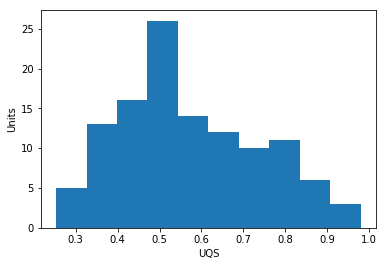

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("UQS")
plt.ylabel("Units")

Text(0,0.5,u'Workers')

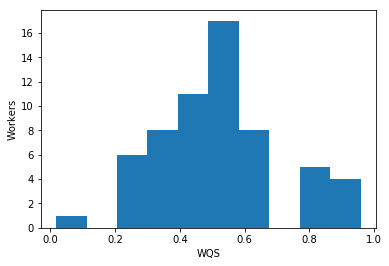

In [6]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("WQS")
plt.ylabel("Workers")

## Update results with reviewers and NIST annotations

In [7]:
import pandas as pd
import numpy as np

gt = pd.read_csv("../ground_truth_data/reviewers_pilot_aggregated_judgments.csv")

results["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results["units"])), index=results["units"].index)
results["units"]['none_score'] = pd.Series(np.random.randn(len(results["units"])), index=results["units"].index)
results["units"]["reviewers_rel"] = pd.Series(np.random.randn(len(results["units"].index)), index=results["units"].index)
results["units"]["reviewers_rel_merged"] = pd.Series(np.random.randn(len(results["units"].index)), index=results["units"].index)
results["units"]["rel_merged"] = pd.Series(np.random.randn(len(results["units"].index)), index=results["units"].index)

for i in range(0, len(results["units"].index)):
    maxVal = 0.0
    found = False
    for key, value in results["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results["units"]['none_score'].iloc[i] = 0.0
        
    for j in range(0, len(gt.index)):
        if (results["units"]["input.topic"].iloc[i] == gt["topic"].iloc[j]) and (results["units"]["input.document_id"].iloc[i] == gt["document_id"].iloc[j]):
            results["units"]["reviewers_rel"].iloc[i] = gt["reviewers_rel"].iloc[j]
            results["units"]["reviewers_rel_merged"].iloc[i] = gt["reviewers_rel_merged"].iloc[j]
            results["units"]["rel_merged"].iloc[i] = gt["nist_rel_merged"].iloc[j]

## Print results to files

In [8]:
# print results for units
results["units"].to_csv("../Results/Pilot_2P-RndPar-NoHigh/units_Pilot_2P-RndPar-NoHigh.csv", index=False)

# print results for workers
results["workers"].to_csv("../Results/Pilot_2P-RndPar-NoHigh/workers_Pilot_2P-RndPar-NoHigh.csv", index=False) 

## Comparison with reviewers and NIST annotations

In [9]:
def compute_F1_score_relevant(dataset):
    nyt_f1 = np.zeros(shape=(100, 2))
    for idx in range(0, 100):
        thresh = (idx + 1) / 100.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for gt_idx in range(0, len(dataset.index)):
            if dataset['max_relevance_score'].iloc[gt_idx] >= thresh:
                if dataset["reviewers_rel_merged"].iloc[gt_idx] == 1:
                    tp = tp + 1.0
                else:
                    fp = fp + 1.0
            else:
                if dataset["reviewers_rel_merged"].iloc[gt_idx] == 1:
                    fn = fn + 1.0
                else:
                    tn = tn + 1.0

        nyt_f1[idx, 0] = thresh
        if tp != 0:
            nyt_f1[idx, 1] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 1] = 0
    return nyt_f1


def compute_F1_score_not_relevant(dataset):
    nyt_f1 = np.zeros(shape=(100, 2))
    for idx in range(0, 100):
        thresh = (idx + 1) / 100.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for gt_idx in range(0, len(dataset.index)):
            if dataset['max_relevance_score'].iloc[gt_idx] < thresh:
                if dataset["reviewers_rel_merged"].iloc[gt_idx] == 0:
                    tp = tp + 1.0
                else:
                    fp = fp + 1.0
            else:
                if dataset["reviewers_rel_merged"].iloc[gt_idx] == 0:
                    fn = fn + 1.0
                else:
                    tn = tn + 1.0

        nyt_f1[idx, 0] = thresh
        if tp != 0:
            nyt_f1[idx, 1] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 1] = 0
    return nyt_f1

In [10]:
expertsF1_notrelevant = 0.796610169492
expertsF1_relevant = 0.803278688525

In [11]:
crowdF1_notrelevant = compute_F1_score_not_relevant(results["units"])
crowdF1_relevant = compute_F1_score_relevant(results["units"])

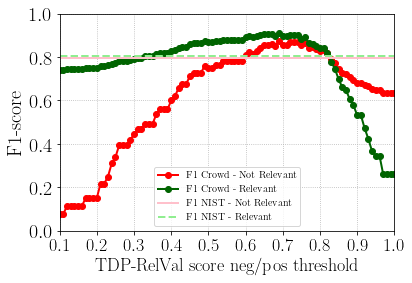

In [12]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['figure.figsize'] = 6, 4
plt.plot(crowdF1_notrelevant[:,0], crowdF1_notrelevant[:,1], 'bo-', color = 'red', lw = 2, label = "F1 Crowd - Not Relevant")
plt.plot(crowdF1_relevant[:,0], crowdF1_relevant[:,1], 'bo-', color = 'darkgreen', lw = 2, label = "F1 Crowd - Relevant")

plt.axhline(y = expertsF1_notrelevant, ls = '-', color = 'pink', lw = 2, label = "F1 NIST - Not Relevant")
plt.axhline(y = expertsF1_relevant, ls = '--', color = 'lightgreen', lw = 2, label = "F1 NIST - Relevant")
plt.xlim(0.1,1.0)
plt.xlabel("TDP-RelVal score neg/pos threshold", fontsize=18)
plt.ylabel("F1-score", fontsize=20)
plt.ylim(0.0,1.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
leg = plt.legend()
leg.get_frame().set_alpha(0.8)
plt.grid(ls=':')
plt.savefig("../Plots/2p_withoutHighlight_F1_random.eps",  bbox_inches='tight', format="eps", dpi=1000)
plt.show()
plt.close()